# ID2222 Data Mining - Homework 2

Notebook by Beatrice Insalata, Laura Puccioni

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

For this task, we are asked to implement the A-Priori algorithm to identify frequent itemsets with a support of at least 's' in a sales transactions dataset. We have used the Python language to evaluate and validate the A-Priori implementation on the given dataset.

## Dataset
Our dataset consists of a sale transaction database (T10I4D100K). The dataset contains 100,000 baskets summing up to 1,010,228 items, with a market size of 870 different items.

In [3]:
#Here we read from a file .dat assuming that on every row of the file there is a basket of items and create a list of baskets

with open('T10I4D100K.dat', "r") as f:
    baskets = list(
        map(
            lambda basket: [int(item_id) for item_id in basket.split()],
            f.read().splitlines()
        )
    )
f.close()

# A-Priori Algorithm Implementation

The Apriori algorithm operates in two passes. In the initial pass, it scans through the baskets, counting the occurrences of each individual item (singletons). In the subsequent pass, the algorithm revisits the baskets, focusing only on pairs where both elements are identified as frequent during the first pass. This process continues iteratively, incrementing the itemset size with each pass. The primary aim is to efficiently identify and prune non-frequent itemsets, ultimately discovering frequent itemsets and their support levels in the dataset.

The iterative nature of the algorithm allows it to progressively explore larger itemsets while leveraging the knowledge gained from previous passes. This two-pass strategy minimizes the need for multiple scans of the entire dataset and optimizes the discovery of frequent itemsets.

## Pass 1 : Find frequent singletons

During the initial pass, the Apriori algorithm identifies frequent single elements, or 1-itemsets, within the dataset. The term "frequent" here implies that these individual elements occur with a frequency at least equal to a specified threshold called "support". Essentially, this step involves finding and recording items that are individually popular or common, laying the foundation for subsequent steps in discovering larger sets of items with significant occurrences.

In [34]:
"""
This function takes as arguments the set of baskets and the threshold called "support", 
and returns the set of frequent singletons, that is the frequent 1-item sets.
"""
def find_frequent_singletons_with_support(baskets, support):

    occurrences = {} # a dictionary containing occurence of items in baskets
    for itemset in baskets:
        for item in itemset:
            if item not in occurrences: # this item didn't exist in previous baskets, initialize with 1
                occurrences[item] = 1
            else:
                occurrences[item] += 1

    print(f'The market contains {len(occurrences)} different items.')
    print(f'The average support is {np.mean(list(occurrences.values())):.2f}')
    return {key : value for key, value in occurrences.items() if value >= support}

We can visualize how the step 1 works on a small set of items, for example using the first 5 baskets of the given dataset:

In [35]:
example_dataset = baskets[0:5]
print(example_dataset)

[[25, 52, 164, 240, 274, 328, 368, 448, 538, 561, 630, 687, 730, 775, 825, 834], [39, 120, 124, 205, 401, 581, 704, 814, 825, 834], [35, 249, 674, 712, 733, 759, 854, 950], [39, 422, 449, 704, 825, 857, 895, 937, 954, 964], [15, 229, 262, 283, 294, 352, 381, 708, 738, 766, 853, 883, 966, 978]]


If we aim to set the support threshold at 2, our goal is to identify elements that occur at least twice in the dataset. This process can be done manually to validate the correctness of the previous function. In this specific case, the elements 39, 704, 825, and 934 meet the criteria, appearing 2, 2, 3, and 2 times, respectively. Consequently, our resulting list of singletons is {39, 704, 825, 934}. To verify this, we can use the find_frequent_singletons_with_support function on the example_dataset with a support threshold of 2:

In [36]:
find_frequent_singletons_with_support(example_dataset, 2)

The market contains 53 different items.
The average support is 1.09


{825: 3, 834: 2, 39: 2, 704: 2}

## Pass 2: Find frequent itemsets iteratively
Following the identification of frequent singletons, the A-priori algorithm proceeds to iteratively discover frequent itemsets.

The initial phase of "pass 2" is referred to as the "join step", where candidate sets are generated utilizing the frequent itemsets identified in the preceding step. The following function is responsible for generating these candidate sets.

In [37]:
def generate_candidates(prev_frequent_itemsets, k):
    candidates = dict()
    
    # Ensure prev_frequent_itemsets only contains iterable elements
    prev_frequent_itemsets = [itemset if isinstance(itemset, (list, tuple)) else [itemset] for itemset in prev_frequent_itemsets]

    #Union of two previous itemsets
    for i in range(len(prev_frequent_itemsets)):
        for j in range(i + 1, len(prev_frequent_itemsets)):
            union_set = set(prev_frequent_itemsets[i]) | set(prev_frequent_itemsets[j])
            if len(union_set) == k + 1:
                candidates[(tuple(sorted(union_set)))] = 0
    
    return candidates

To observe how the function works, we can apply it to the example_dataset using the set of singletons identified earlier: {39, 704, 825, 834}. Executing the generate_candidates function will yield all possible unique combinations of these four numbers.

In [38]:
candidates = generate_candidates(find_frequent_singletons_with_support(example_dataset, 2), 1) #k is the previous step
print(candidates)

The market contains 53 different items.
The average support is 1.09
{(825, 834): 0, (39, 825): 0, (704, 825): 0, (39, 834): 0, (704, 834): 0, (39, 704): 0}


It's important to note that the outcome is a dictionary. Here, the keys represent the generated candidates, each paired with an initial count of 0. This count will be updated later during the process, as we enumerate their occurrences in the baskets of the dataset to determine their status as either frequent or not.

As can be seen, we have obtained 6 new sets, each of which is formed by a combination of the singletons found at step 1. If we run the function again, incrementing k, we obtain 4 sets, each of which is a combination of the ones found at the previous step:

In [39]:
generate_candidates(candidates, 2)

{(39, 825, 834): 0, (704, 825, 834): 0, (39, 704, 825): 0, (39, 704, 834): 0}


Following the generation of candidate sets, the next step involves verifying if these sets occur a number of times greater than or equal to the defined support threshold (support). To achieve this, the process begins by checking if these candidates are subsets of any of the baskets. If a match is found, the count of their occurrences is incremented. Subsequently, it is verified whether the count surpasses or equals the specified support.

To address the issue of slow computation, an efficient implementation of this step involves computing all possible subsets of length k within each basket. Subsequently, checking if each generated combination is present in the set of candidates. If a match is found, the corresponding candidate's count is incremented, indicating the occurrence of that subset. This approach can be seen in the following function:

In [40]:
def filter_with_support(candidate_itemsets, baskets, min_support, k):

    for basket in baskets:
        basket_combinations = itertools.combinations(basket, k)
        for combination in basket_combinations:
            if combination in candidate_itemsets:
                candidate_itemsets[combination] += 1

    # Filter frequent itemsets
    frequent_itemsets = {itemset : count for itemset, count in candidate_itemsets.items() if count >= min_support}

    return frequent_itemsets

We can see how this function works on our example_dataset. Indeed, while the candidates we obtained are: (39, 834), (704, 825), (39, 704), (704, 834), (39, 825), (825, 834). Two of them occur only once among the original baskets, specifically (39, 834) and (704, 834), and will, therefore, be pruned.

In [41]:
filter_with_support(candidates, example_dataset, 2, 2)

{(825, 834): 2, (39, 825): 2, (704, 825): 2, (39, 704): 2}

## Algorithm Implementation
At this point we have all the functions needed to run the apriori algorithm.
The algorithm encompasses the following steps:
- Identify frequent singletons.
- Iterate until there are no more frequent itemsets. At each iteration:
    - Generate candidate itemsets.
    - Determine the frequent itemsets among the generated candidates.
    - Print the identified frequent itemsets.

This approach ensures the systematic discovery of frequent itemsets through an iterative process, facilitating the efficient extraction of meaningful patterns from the dataset.

In [168]:
def apriori(baskets, support):
    k = 0

    # Find frequent singletons
    frequent_singletons = find_frequent_singletons_with_support(baskets, support)
    frequent_itemsets = frequent_singletons

    #Print frequent singletons
    print(f"Frequent {1}-itemsets:", frequent_itemsets)
    result_itemsets_with_freq = frequent_singletons
    #number_of_freq_items = len(frequent_itemsets)

    #Iterate incrementing k at each step, until there are no more frequent itemsets
    while frequent_itemsets:
        k += 1
        # Generate candidate itemsets
        candidate_itemsets = generate_candidates(frequent_itemsets, k)

        #Filter frequent items
        frequent_itemsets = filter_with_support(candidate_itemsets, baskets, support, k+1)
        # Print frequent itemsets of size k
        if len(frequent_itemsets) > 0:
            print(f"Frequent {k+1}-itemsets:", frequent_itemsets)
            result_itemsets_with_freq.update(frequent_itemsets)
            #number_of_freq_items += len(frequent_itemsets)
        else:
            print("DONE!")
    return result_itemsets_with_freq

We can see how it works on our original set of baskets. The result will show all the frequent itemsets found with their frequency in the dataset.

In [169]:
start = time.time()
freq_items = apriori(baskets, 1000)
duration = time.time() - start
print(duration)

The market contains 870 different items.
The average support is 1161.18
Frequent 1-itemsets: {25: 1395, 52: 1983, 240: 1399, 274: 2628, 368: 7828, 448: 1370, 538: 3982, 561: 2783, 630: 1523, 687: 1762, 775: 3771, 825: 3085, 834: 1373, 39: 4258, 120: 4973, 205: 3605, 401: 3667, 581: 2943, 704: 1794, 814: 1672, 35: 1984, 674: 2527, 733: 1141, 854: 2847, 950: 1463, 422: 1255, 449: 1890, 857: 1588, 895: 3385, 937: 4681, 964: 1518, 229: 2281, 283: 4082, 294: 1445, 381: 2959, 708: 1090, 738: 2129, 766: 6265, 853: 1804, 883: 4902, 966: 3921, 978: 1141, 104: 1158, 143: 1417, 569: 2835, 620: 2100, 798: 3103, 185: 1529, 214: 1893, 350: 3069, 529: 7057, 658: 1881, 682: 4132, 782: 2767, 809: 2163, 947: 3690, 970: 2086, 227: 1818, 390: 2685, 71: 3507, 192: 2004, 208: 1483, 279: 3014, 280: 2108, 496: 1428, 530: 1263, 597: 2883, 618: 1337, 675: 2976, 720: 3864, 914: 4037, 932: 1786, 183: 3883, 217: 5375, 276: 2479, 653: 2634, 706: 1923, 878: 2047, 161: 2320, 175: 2791, 177: 4629, 424: 1448, 490: 1066

## Experiments
The support value of 1000 has been decided based on the average support computed, which is 1161.18. In order to understand how the value of the support affects the execution time and the number of frequent itemsets found, we can make some experiments varying its value.

In [189]:
supports = [250, 500, 750, 1000, 1250, 1500]
durations = []
number_of_freq_items = []

for s in supports:
  print("SUPPORT = " + str(s))
  start = time.time()
  num_items = len(apriori(baskets, s))
  duration = time.time() - start

  durations.append(duration)
  number_of_freq_items.append(num_items)

SUPPORT = 250
The market contains 870 different items.
The average support is 1161.18
Frequent 1-itemsets: {25: 1395, 52: 1983, 164: 744, 240: 1399, 274: 2628, 328: 663, 368: 7828, 448: 1370, 538: 3982, 561: 2783, 630: 1523, 687: 1762, 730: 602, 775: 3771, 825: 3085, 834: 1373, 39: 4258, 120: 4973, 124: 294, 205: 3605, 401: 3667, 581: 2943, 704: 1794, 814: 1672, 35: 1984, 249: 615, 674: 2527, 712: 845, 733: 1141, 759: 788, 854: 2847, 950: 1463, 422: 1255, 449: 1890, 857: 1588, 895: 3385, 937: 4681, 954: 366, 964: 1518, 15: 458, 229: 2281, 262: 660, 283: 4082, 294: 1445, 352: 902, 381: 2959, 708: 1090, 738: 2129, 766: 6265, 853: 1804, 883: 4902, 966: 3921, 978: 1141, 26: 527, 104: 1158, 143: 1417, 320: 540, 569: 2835, 620: 2100, 798: 3103, 7: 997, 185: 1529, 214: 1893, 350: 3069, 529: 7057, 658: 1881, 682: 4132, 782: 2767, 809: 2163, 849: 459, 947: 3690, 970: 2086, 227: 1818, 390: 2685, 71: 3507, 192: 2004, 208: 1483, 272: 659, 279: 3014, 280: 2108, 300: 582, 333: 483, 496: 1428, 530: 1

From the following plot we can visualize how the execution time reduces significantly as the support value increases, This is due to the fact that with a very large support, we will obviously find significantly less itemsets that occur that many times.

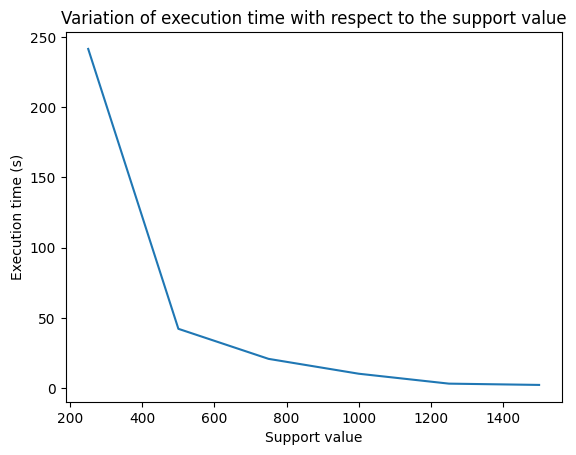

In [190]:
plt.plot(supports, durations)
plt.xlabel('Support value')
plt.ylabel('Execution time (s)')
plt.title('Variation of execution time with respect to the support value')
plt.show()

 From the following plot, instead, we can visualize how the number of frequent itemsets changes in relation to variations in the support value increases. As the support value increases, there is a gradual reduction in the abundance of frequent itemsets.

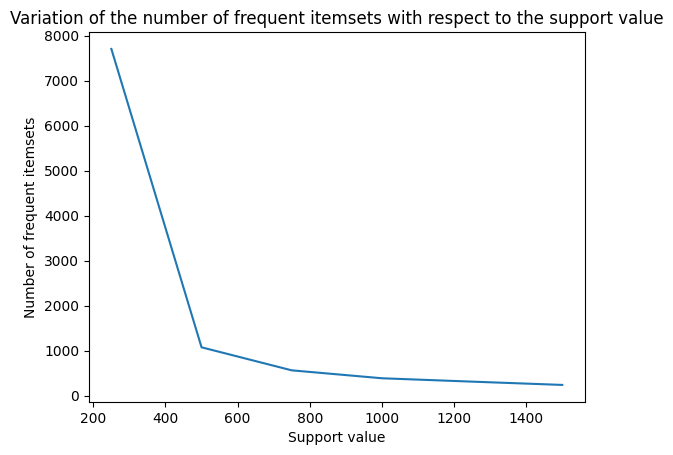

In [191]:
plt.plot(supports, number_of_freq_items)
plt.xlabel('Support value')
plt.ylabel('Number of frequent itemsets')
plt.title('Variation of the number of frequent itemsets with respect to the support value')
plt.show()

# Association Rules

Association rule mining is a technique used in data mining to discover relationships between items in a dataset. The goal of association rule mining is to identify relationships between items in a dataset that occur frequently together. Once the frequent item sets (with respect to the support threshold) are found, association rules can be generated by using the concept of confidence, which is the ratio of the number of transactions that contain the item set and the number of transactions that contain the antecedent (left-hand side) of the rule.
A practicle example is: it is likely to find that if a customer in a storebuys Milk and bread he/she also buys Butter. So the association rule is [‘milk]^[‘bread’]=>[‘butter’]. So the seller can suggest the customer buy butter if he/she buys Milk and Bread.

There are two main parameters to take into account with association rules:
- Support : It is one of the measures of interestingness. This tells about the usefulness and certainty of rules. 5% Support means total 5% of transactions in the database follow the rule.
Support(A -> B) = Support_count(A ∪ B) (number of transactions in which A and B both are present).
- Confidence: A confidence of 60% means, for example, that 60% of the customers who purchased a milk and bread also bought butter. Confidence(A -> B) = Support_count(A ∪ B) / Support_count(A)

If a rule satisfies both minimum support and minimum confidence, it is a strong rule.

In [192]:
#The support value is passed through frequent_itemsets, which is a dictionary containing the freq itemsets associated with their support value.
def generate_association_rules(frequent_itemsets, confidence):
    association_rules = {}

    for key, value in frequent_itemsets.items():
        if type(key) != int:
            key_set = frozenset(key)  # Convert key tuple to a frozenset
            for item in key:
                antecedent = frozenset(key_set - frozenset([item]))
                consequent = frozenset([item])
                if len(antecedent) > 1:
                    calculated_confidence = value / frequent_itemsets.get(tuple(sorted(antecedent)), 1.0) #to retrieve the support count of the antecedent (if the antecedent set has more than one value) from the frequent_itemsets dictionary. If the antecedent set is not found, it defaults to 1.0 to avoid division by zero errors.
                else:
                    calculated_confidence = value / frequent_itemsets.get(next(iter(antecedent)), 1.0) #to retrieve the support count of the antecedent (if the antecedent set has only one value) from the frequent_itemsets dictionary. If the antecedent set is not found, it defaults to 1.0 to avoid division by zero errors.

                if calculated_confidence >= confidence:
                    association_rules[(antecedent, consequent)] = calculated_confidence
    return association_rules

Let's see an example of how the generation of association rules works on the example_dataset, with support 2 and confidence
We first run the apriori algorithm to find the frequent itemsets:

In [193]:
frequent_it = apriori(example_dataset, 2)

The market contains 53 different items.
The average support is 1.09
Frequent 1-itemsets: {825: 3, 834: 2, 39: 2, 704: 2}
Frequent 2-itemsets: {(825, 834): 2, (39, 825): 2, (704, 825): 2, (39, 704): 2}
Frequent 3-itemsets: {(39, 704, 825): 2}
DONE!


And then we generate the association rules. In this case, if we impose a confidence of 0.7, we will obtain:
834 -> 825 (c = 2/2 = 1), ... , (39,825) -> 704 (c = 2/2 = 1)
While the following association rule will not be considered as their confidence is < 0.7:
825 -> 834 (c = 2/3 = 0.67)

In [194]:
generate_association_rules(frequent_it, 0.7)

{(frozenset({834}), frozenset({825})): 1.0,
 (frozenset({39}), frozenset({825})): 1.0,
 (frozenset({704}), frozenset({825})): 1.0,
 (frozenset({704}), frozenset({39})): 1.0,
 (frozenset({39}), frozenset({704})): 1.0,
 (frozenset({704, 825}), frozenset({39})): 1.0,
 (frozenset({39, 825}), frozenset({704})): 1.0,
 (frozenset({39, 704}), frozenset({825})): 1.0}

We can now generate the association rules for the frequent itemsets we have found before with support = 1000

In [195]:
generate_association_rules(freq_items, 0.5)

{(frozenset({704}), frozenset({825})): 0.6142697881828316,
 (frozenset({704}), frozenset({39})): 0.617056856187291,
 (frozenset({227}), frozenset({390})): 0.577007700770077,
 (frozenset({704, 825}), frozenset({39})): 0.9392014519056261,
 (frozenset({39, 825}), frozenset({704})): 0.8719460825610783,
 (frozenset({39, 704}), frozenset({825})): 0.9349593495934959}

Now we can vary the confidence threshold to analyse how it affects the execution time and the number of rules generated.

In [196]:
confidences = [0.1, 0.3, 0.5, 0.7, 0.9]
durations = []
n_rules = []

for c in confidences:
  start = time.time()
  rules = generate_association_rules(freq_items, c)
  duration = time.time() - start

  durations.append(duration)
  n_rules.append(len(rules))

As can be seen from the following graph, the execution time of this task is minimal and independent of the number of rules.

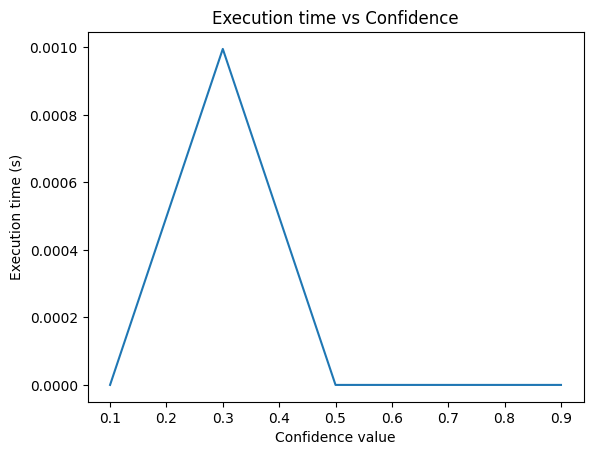

In [197]:
plt.plot(confidences, durations)
plt.xlabel('Confidence value')
plt.ylabel('Execution time (s)')
plt.title('Execution time vs Confidence')
plt.show()

Looking at the number of rules generated with respect to the confidence threshold, as expected, the number of rules generated decrease with the increase of the confidence threshold as less associations are as strong as required.

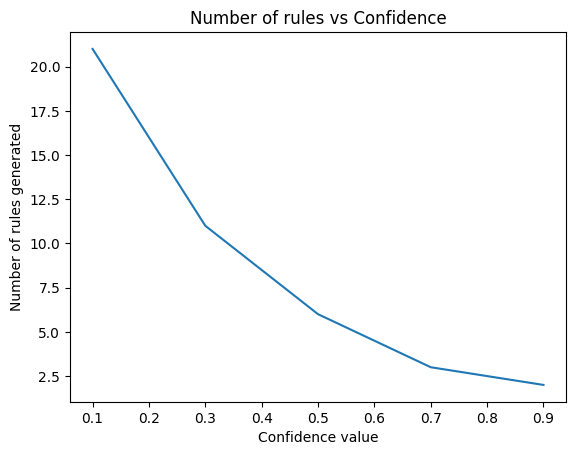

In [198]:
plt.plot(confidences, n_rules)
plt.xlabel('Confidence value')
plt.ylabel('Number of rules generated')
plt.title('Number of rules vs Confidence')
plt.show()

## Conclusions
The project's objective was to implement the Aprori algorithm and generate association rules, to derive meaningful insights from our transaction dataset. The following key findings and observations were made:
- The Apriori algorithm efficiently discovered frequent itemsets by employing a level-wise search strategy based on support thresholds. The implementation involved iterative scans of the dataset to generate candidate itemsets, followed by pruning infrequent itemsets to reduce computational complexity. We then compared various support values to understand how it affects the execution time, discovering that a higher support value reflects on a lower execution time.
- The association rules generated revealed the relationships and associations among items within our transaction data. We uncovered significant rules demonstrating strong correlations between specific items. Also in this case we experimented with different confidence values to understand how it affects execution time and number of rules generated